In [7]:
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO
import pandas as pd
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
#import optuna

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, AveragePooling2D
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping, Callback
import tensorflow as tf

In [8]:
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


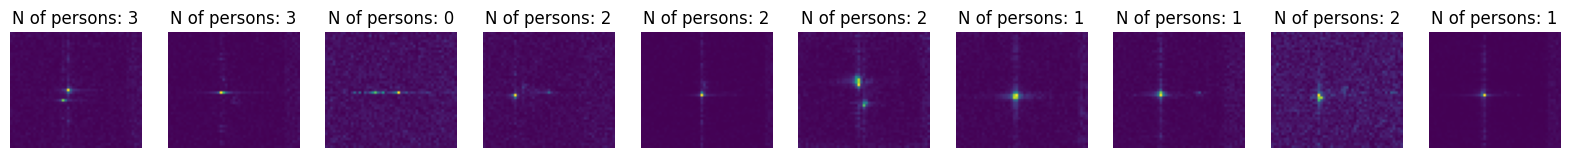

In [51]:
data = np.load('Data/NPZ/data.npz')
x_train_data = data['X_train']
y_train_data = pd.read_csv("Data/y_train.csv")
y_train_data  = y_train_data["target"].values

def display_random_images(x_data: np.array, y_true: np.array, count: int = 10) -> None:
    index = len(x_data)
    selected_ind = np.random.choice(index, count)
    selected_img = x_data[selected_ind]
    selected_true_labels = y_true[selected_ind]

    plt.figure(figsize=(20, 5))
    for i in range(count):
        plt.subplot(1, count, i+1)
        plt.imshow(selected_img[i])
        plt.title(f'N of persons: {selected_true_labels[i]}')
        plt.axis('off')
    plt.show()

display_random_images(data['X_train'],y_train_data)

In [18]:
X_train_scaled = x_train_data.astype('float32') / 255.0
print(X_train_scaled.size)
y_train_encoded = to_categorical(y_train_data, num_classes=4)
print(y_train_encoded)

148550760
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]]


In [19]:
x_train, x_test, y_train, y_test = train_test_split(X_train_scaled ,y_train_encoded, test_size=0.2)

In [26]:
#https://pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/

model = Sequential()
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=(45, 51, 4)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(128, kernel_size=(4, 4), activation='relu'))
model.add(AveragePooling2D(pool_size=(4, 4)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax'))
model.summary()


optimizer = Adam(learning_rate = 0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 43, 49, 128)       4736      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 21, 24, 128)      0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 21, 24, 128)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 19, 22, 256)       295168    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 9, 11, 256)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 9, 11, 256)       

In [27]:
history = model.fit(x_train, y_train, epochs=170, batch_size=16, validation_split = 0.2)

Epoch 1/170
648/648 [==============================] - 7s 9ms/step - loss: 0.9316 - accuracy: 0.5770 - val_loss: 0.6031 - val_accuracy: 0.7601
Epoch 2/170
648/648 [==============================] - 6s 9ms/step - loss: 0.5519 - accuracy: 0.7708 - val_loss: 0.4623 - val_accuracy: 0.8111
Epoch 3/170
648/648 [==============================] - 6s 10ms/step - loss: 0.4445 - accuracy: 0.8217 - val_loss: 0.4419 - val_accuracy: 0.8154
Epoch 4/170
648/648 [==============================] - 6s 9ms/step - loss: 0.3908 - accuracy: 0.8464 - val_loss: 0.3560 - val_accuracy: 0.8525
Epoch 5/170
648/648 [==============================] - 6s 9ms/step - loss: 0.3416 - accuracy: 0.8635 - val_loss: 0.3554 - val_accuracy: 0.8494
Epoch 6/170
648/648 [==============================] - 6s 9ms/step - loss: 0.3170 - accuracy: 0.8742 - val_loss: 0.2636 - val_accuracy: 0.9007
Epoch 7/170
648/648 [==============================] - 6s 9ms/step - loss: 0.2849 - accuracy: 0.8866 - val_loss: 0.2521 - val_accuracy: 0.899

Test loss: 0.0701388493180275
Test accuracy: 98.2082188129425 %


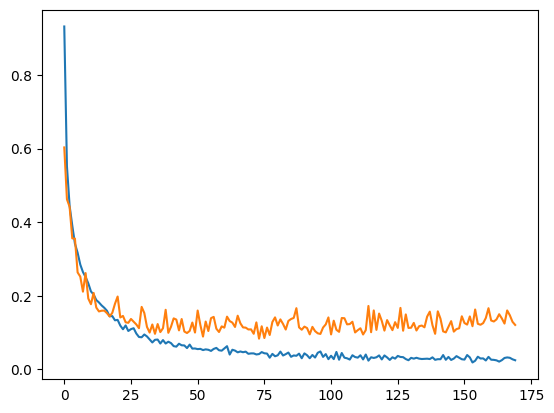

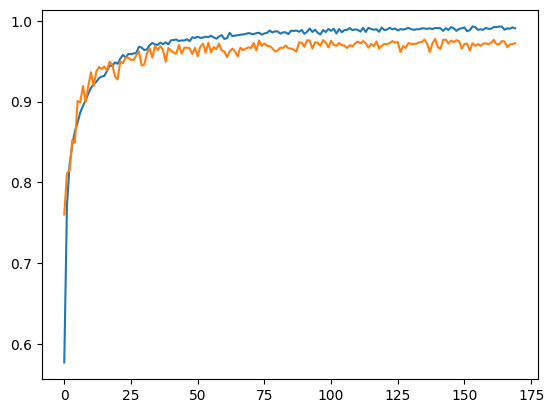

In [28]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print(f'Test accuracy: {score[1]*100} %')

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

102/102 [==============================] - 0s 4ms/step


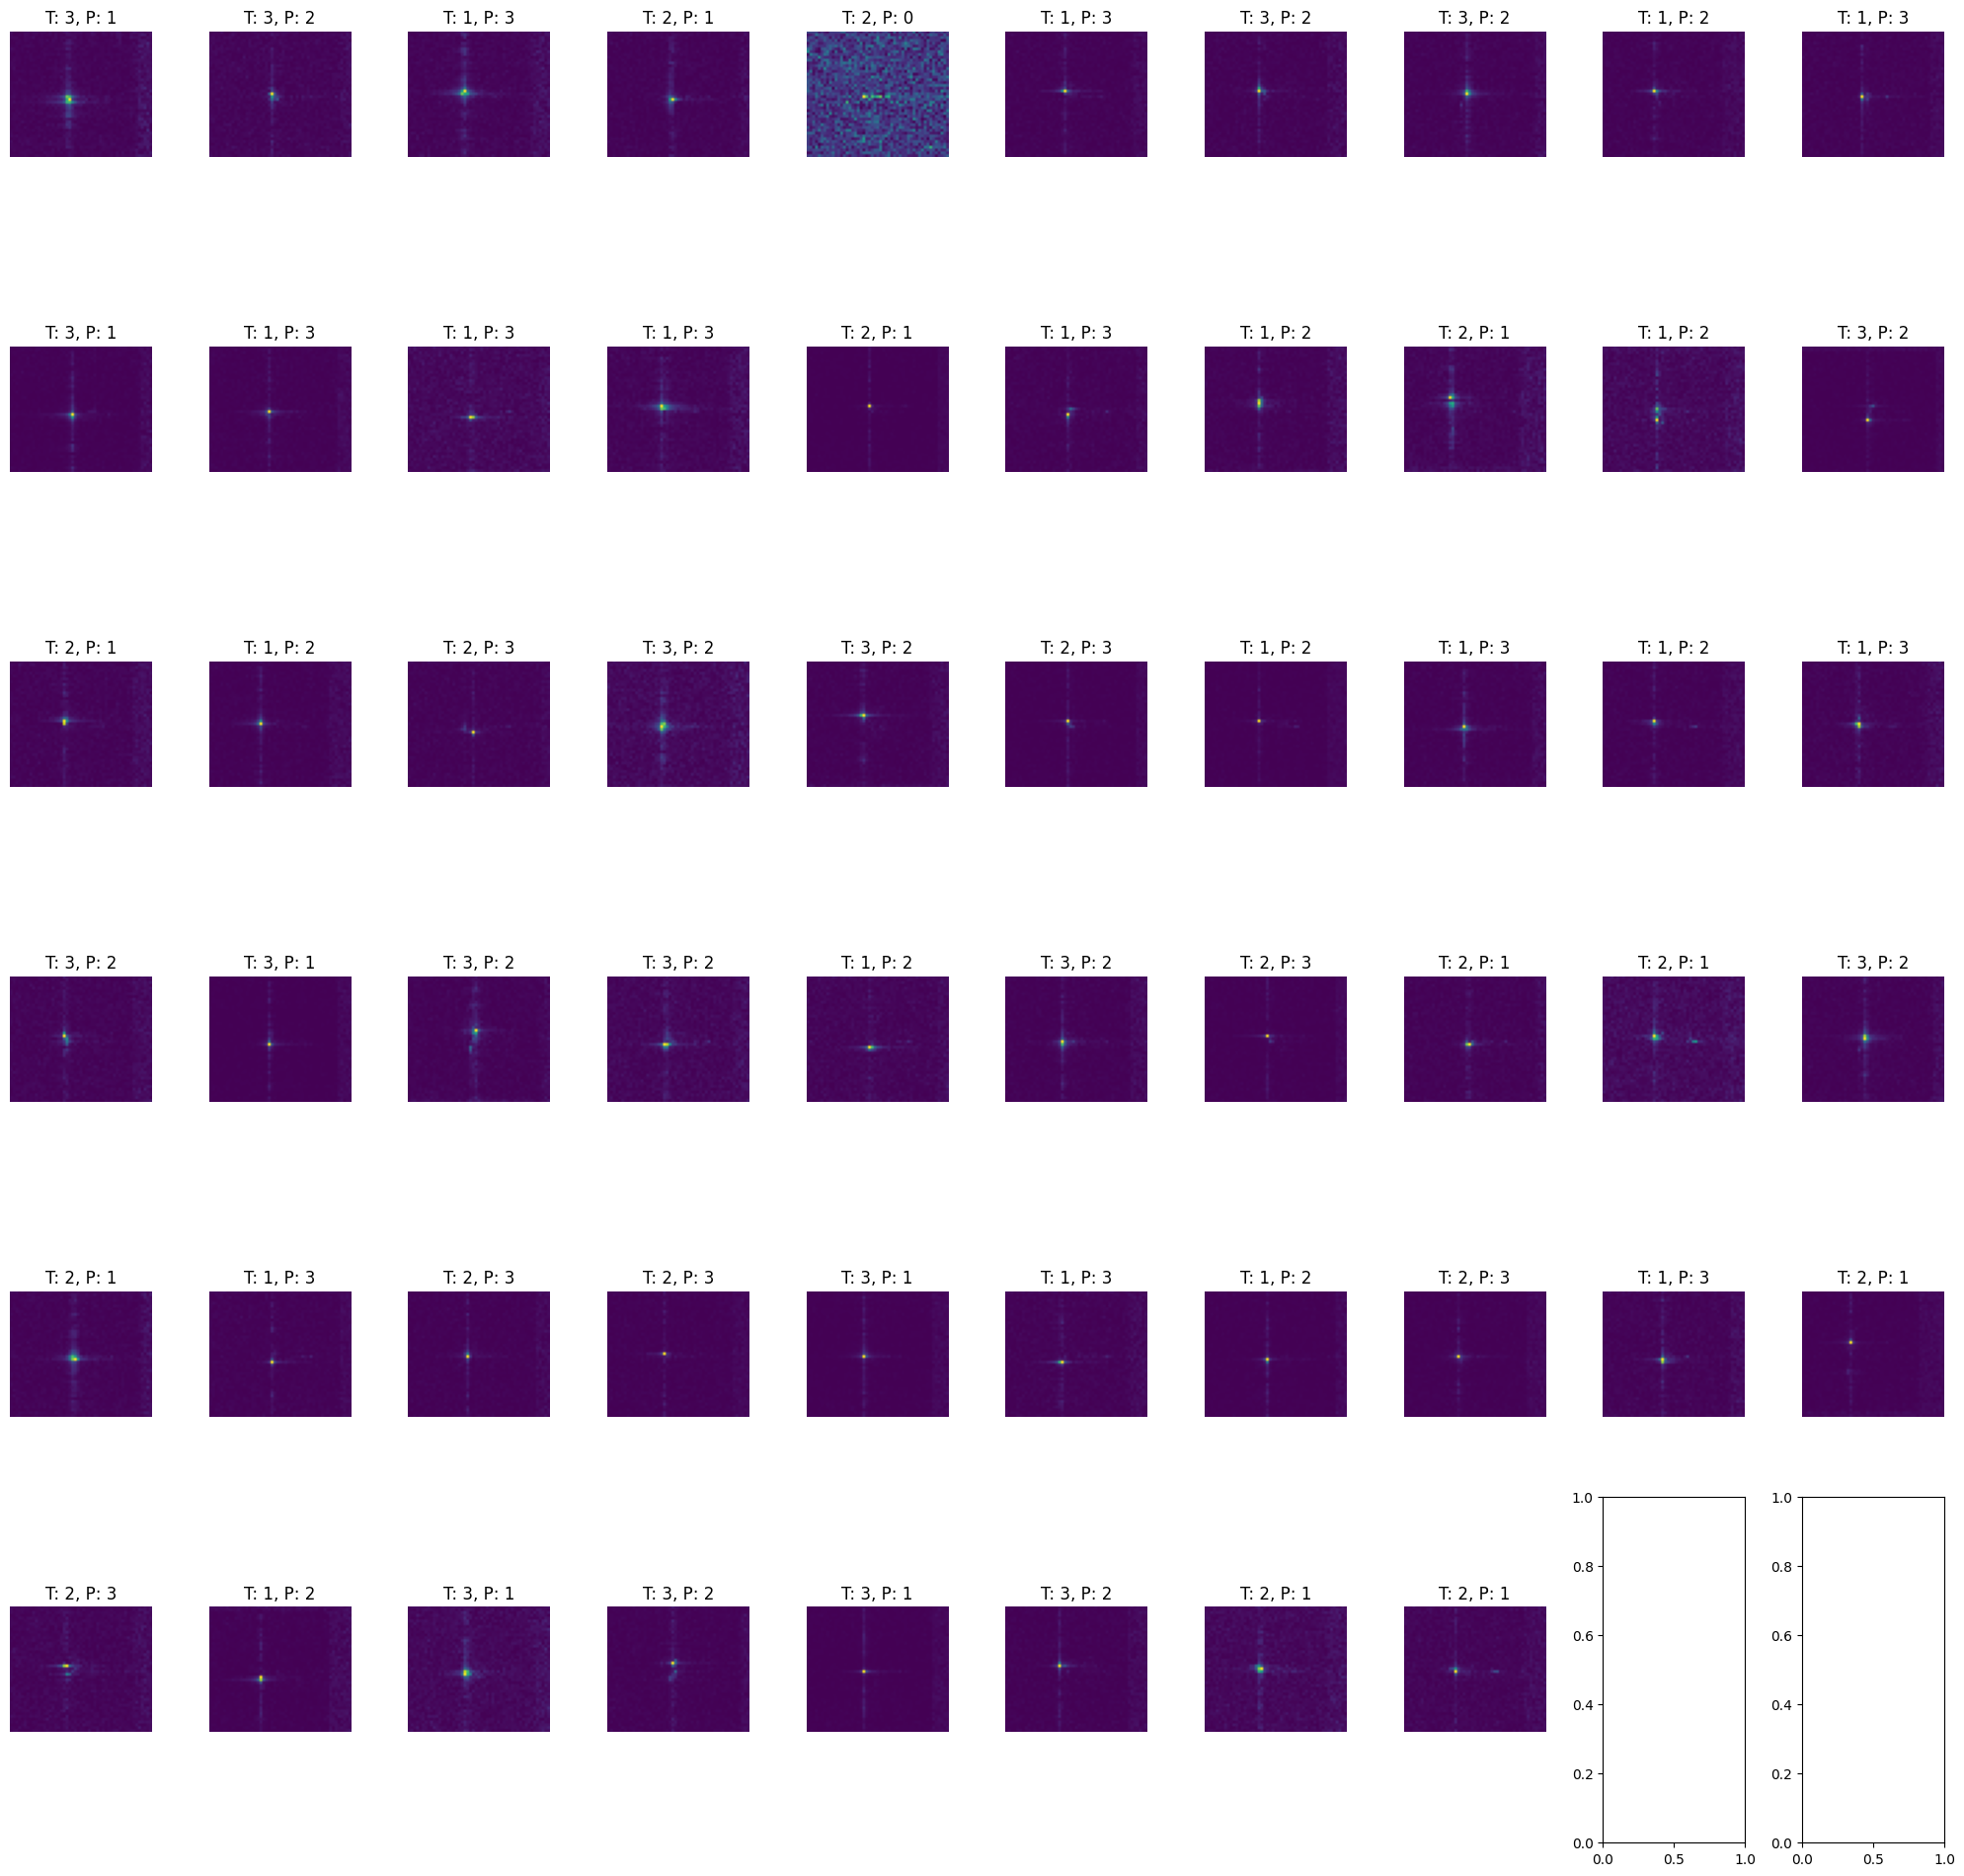

In [48]:
predictions = model.predict(x_test)
pred_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)
mis = np.where(pred_classes != true_classes)[0]

def plot_wrong(x_test, y_test, pred_classes, mis, rows=10, cols=10):
    fig, axes = plt.subplots(rows, cols, figsize=(20, 20))

    for i, index in enumerate(mis[:rows*cols]):
        row = i // cols
        col = i % cols
        ax = axes[row, col]
        ax.imshow(x_test[index])
        ax.set_title(f"T: {np.argmax(y_test[index])}, P: {pred_classes[index]}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

plot_wrong(x_test, y_test, pred_classes,mis,rows=6)
